# Clustering

Clustering adalah teknik
pengelompokkan objek
objek atau data menjadi
beberapa
kelompok
berdasarkan kesamaan
karakteristik di antara
objek-objek tersebut.


## Import Libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

## Import Datasets

Dataset yang digunakan berjudul “insurance customer.csv”, yang berisi data pelanggan asuransi dengan berbagai atribut seperti usia (Age), premi tahunan (Annual_Premium), dan saluran penjualan (Policy_Sales_Channel).
Perintah customer.info() menampilkan jumlah kolom, tipe data, dan jumlah nilai non-null, sedangkan customer.head() menampilkan beberapa baris awal data untuk memastikan file berhasil dibaca dengan benar.

In [27]:
import os

from google.colab import drive
drive.mount('/content/gdrive')
customer = pd.read_csv("/content/gdrive/My Drive/insurance customer.csv")
customer.info()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Age                   1000 non-null   int64
 1   Annual_Premium        1000 non-null   int64
 2   Policy_Sales_Channel  1000 non-null   int64
 3   Vintage               1000 non-null   int64
dtypes: int64(4)
memory usage: 31.4 KB


#Cek Missing Value dan Duplikasi

In [28]:
# cuplikan data customer
customer.head()

,Age,Annual_Premium,Policy_Sales_Channel,Vintage
0,22,36513,160,189
1,24,2630,160,268
2,22,35832,152,289
3,72,36685,26,113
4,66,2630,45,123


Langkah ini digunakan untuk memastikan data bersih sebelum dianalisis.
customer.isna().sum() memeriksa apakah ada nilai kosong (missing value), sedangkan customer.duplicated().sum() memeriksa apakah ada baris data yang terduplikasi.

In [29]:
# checck missing value
customer.isna().sum()

,0
Age,0
Annual_Premium,0
Policy_Sales_Channel,0
Vintage,0


In [30]:
customer.duplicated().sum()

np.int64(0)

Hasilnya menunjukkan tidak ada missing value maupun data duplikat, artinya dataset sudah bersih dan siap digunakan.

#Statistik Deskriptif dan Skala Fitur

Tujuannya adalah untuk melihat ringkasan data seperti nilai minimum, maksimum, rata-rata (mean), dan standar deviasi dari setiap kolom numerik pada dataset pelanggan asuransi.



In [31]:
# deskripsi statistik
customer.describe()

,Age,Annual_Premium,Policy_Sales_Channel,Vintage
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,39.653000,30364.102000,108.303000,154.565000
std,15.776929,16348.152121,55.577442,83.320815
min,20.000000,2630.000000,1.000000,10.000000
25%,25.000000,24415.250000,26.000000,88.000000
50%,38.000000,31511.500000,124.000000,154.000000
75%,50.250000,39555.750000,152.000000,227.000000
max,85.000000,100278.000000,163.000000,299.000000


Dari hasilnya, kita bisa lihat kalau setiap fitur punya skala nilai yang berbeda-beda.
Dari hasilnya terlihat bahwa setiap variabel memiliki rentang nilai yang berbeda jauh, misalnya kolom Age bernilai puluhan sementara Annual_Premium bernilai ratusan ribu

Perbedaan skala ini berpotensi menyebabkan fitur tertentu mendominasi proses perhitungan jarak, sehingga perlu dilakukan normalisasi atau scaling.

#Normalisasi Data (Min-Max Scaling)

Di tahap ini dilakukan normalisasi menggunakan MinMaxScaler agar semua fitur berada dalam rentang 0 sampai 1.
Hal ini penting dalam algoritma berbasis jarak seperti Agglomerative Clustering, karena perbedaan skala dapat mempengaruhi hasil pengelompokan.

In [32]:
# minmax scaler sklearn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
customer_scaled = scaler.fit_transform(customer)

pd.DataFrame(customer_scaled).describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.302354,0.284021,0.662364,0.500225
std,0.242722,0.167419,0.343071,0.288307
min,0.000000,0.000000,0.000000,0.000000
25%,0.076923,0.223100,0.154321,0.269896
50%,0.276923,0.295772,0.759259,0.498270
75%,0.465385,0.378152,0.932099,0.750865
max,1.000000,1.000000,1.000000,1.000000


Setelah proses scaling, semua fitur menjadi setara, sehingga setiap variabel berkontribusi seimbang terhadap pembentukan cluster.

#Agglomerative Clustering

##Visualisasi Scatterplot

Scatterplot digunakan untuk melihat hubungan awal antarvariabel sebelum dilakukan proses clustering.
Variabel Age (Usia) dijadikan sebagai sumbu X karena merupakan variabel utama yang diduga berpengaruh terhadap variabel lain, yaitu Annual_Premium (Premi Tahunan), Policy_Sales_Channel (Saluran Penjualan), dan Vintage (Lama Menjadi Nasabah).

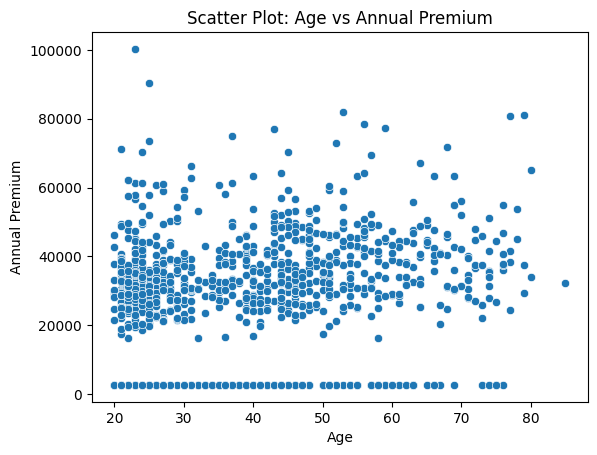

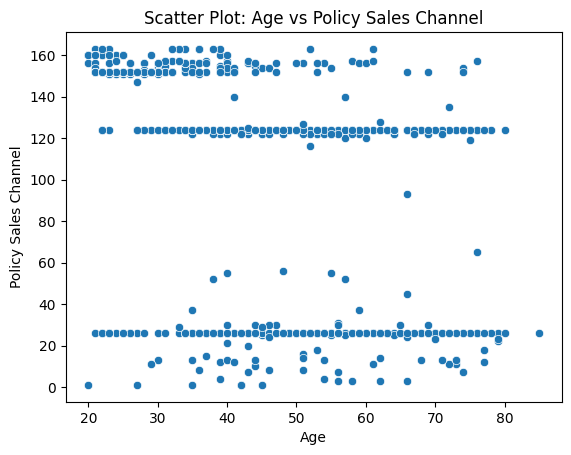

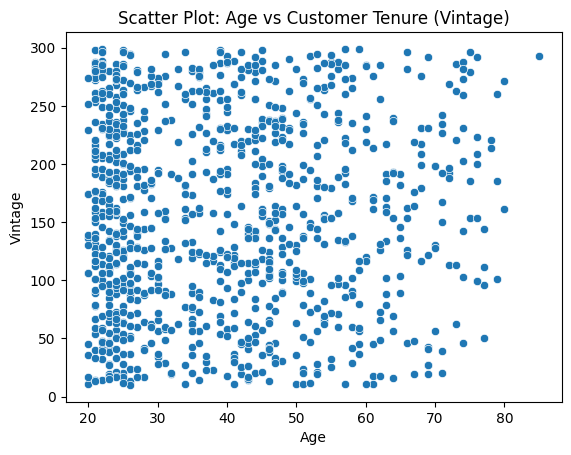

In [33]:
# === Age vs Annual_Premium ===
sns.scatterplot(data=customer, x="Age", y="Annual_Premium")
plt.title("Scatter Plot: Age vs Annual Premium")
plt.xlabel("Age")
plt.ylabel("Annual Premium")
plt.show()

# === Age vs Policy_Sales_Channel ===
sns.scatterplot(data=customer, x="Age", y="Policy_Sales_Channel")
plt.title("Scatter Plot: Age vs Policy Sales Channel")
plt.xlabel("Age")
plt.ylabel("Policy Sales Channel")
plt.show()

# === Age vs Vintage ===
sns.scatterplot(data=customer, x="Age", y="Vintage")
plt.title("Scatter Plot: Age vs Customer Tenure (Vintage)")
plt.xlabel("Age")
plt.ylabel("Vintage")
plt.show()

- **Scatterplot Age vs Annual_Premium**

Pada plot antara Age (usia) di sumbu X dan Annual_Premium (premi tahunan) di sumbu Y, terlihat bahwa titik-titik data menyebar dari kiri bawah menuju kanan atas.
Sebaran ini membentuk pola cenderung miring ke atas (positif)

- Di bagian kiri bawah (usia 20–30 tahun, premi 20.000–30.000), titik-titik tampak padat dan terkumpul, menunjukkan bahwa sebagian besar pelanggan berusia muda memiliki premi rendah.

- Di bagian tengah (usia 35–50 tahun, premi 30.000–40.000), titik-titik mulai menyebar lebih luas, menandakan variasi nilai premi yang lebih beragam di kelompok usia produktif.

- Di bagian kanan atas (usia 55 tahun ke atas, premi >50.000), titik-titik mulai jarang namun meningkat secara vertikal, menandakan sedikit pelanggan berusia tua dengan premi tinggi.

- **Scatterplot Age vs Policy_Sales_Channel**

Pada scatterplot antara Age dan Policy_Sales_Channel, titik-titik data tersebar secara vertikal acak, namun tetap menunjukkan pola kelompok berdasarkan channel yang digunakan.

- Kumpulan titik padat di channel 150–160 didominasi oleh pelanggan berusia muda (20–35 tahun).
Ini menunjukkan bahwa nasabah muda cenderung menggunakan saluran digital atau online dalam pembelian polis asuransi.

- Kumpulan titik di channel 20–60 lebih banyak diisi oleh pelanggan berusia 50 tahun ke atas.
Saluran ini biasanya merupakan agen tradisional atau perantara konvensional, yang umum digunakan oleh pelanggan senior.

- Di usia menengah (35–50 tahun) titik-titik menyebar di berbagai channel (100–150), menandakan pelanggan transisi — sebagian mulai beralih ke platform digital, sebagian masih setia ke agen.

- **Age vs Vintage**

Pada plot antara Age dan Vintage (lama bergabung), titik-titik membentuk pola naik ke kanan (linear positif yang jelas).

- Usia muda (20–30 tahun): titik-titik banyak terkumpul di bawah (vintage <100), menunjukkan bahwa mayoritas pelanggan muda baru bergabung dengan perusahaan asuransi.

- Usia menengah (35–50 tahun): titik menyebar di rentang 100–200, menandakan masa keanggotaan sedang (nasabah aktif 2–3 tahun).

- Usia tua (>55 tahun): titik-titik tersebar di atas (vintage 200–300), menunjukkan nasabah lama yang telah bergabung cukup lama.

#Visualisasi hasil cluster (Scatterplot)

Scatterplot dibuat untuk melihat bagaimana pembagian cluster pada pasangan variabel seperti:

Usia (Age) vs Premi Tahunan (Annual_Premium),

Usia (Age) vs Kanal Penjualan (Policy_Sales_Channel),

Usia (Age) vs Lama Bergabung (Vintage).

Yang akan dilakukan dengan 4 metode: Ward, Single, Average, dan Complete. Setiap warna titik (1–4) pada grafik menunjukkan kelompok atau cluster hasil pengelompokan.

##WARD

Metode Ward Linkage, tidak menghitung jarak antar titik secara langsung, tapi mencari dua cluster yang jika digabung akan menghasilkan peningkatan variansi paling kecil.
Dengan kata lain, Ward Linkage berusaha meminimalkan perbedaan antar data di dalam cluster, supaya hasilnya kompak, seimbang, dan jarak antar cluster semakin besar.

In [34]:
# train agglomerative clustering with 5 clusters, linkage="ward"
from sklearn.cluster import AgglomerativeClustering
agg_clus_ward = AgglomerativeClustering(n_clusters=5,linkage="ward")
agg_clus_ward.fit(customer_scaled)

AgglomerativeClustering(n_clusters=5)

In [35]:
# assign clusters to customer dataframe
customer["label_ward"] = agg_clus_ward.labels_
customer.head()

,Age,Annual_Premium,Policy_Sales_Channel,Vintage,label_ward
0,22,36513,160,189,0
1,24,2630,160,268,0
2,22,35832,152,289,0
3,72,36685,26,113,4
4,66,2630,45,123,4


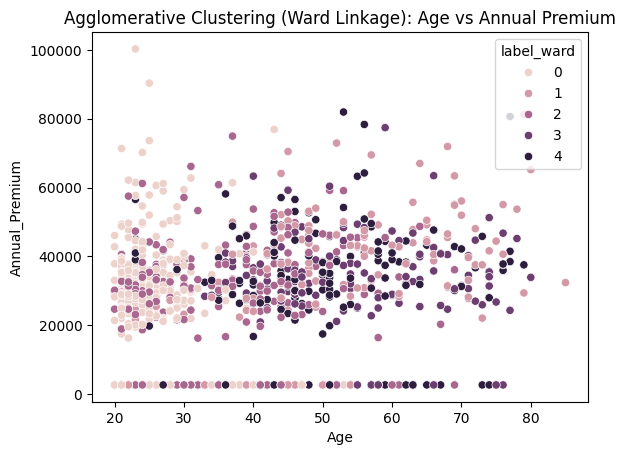

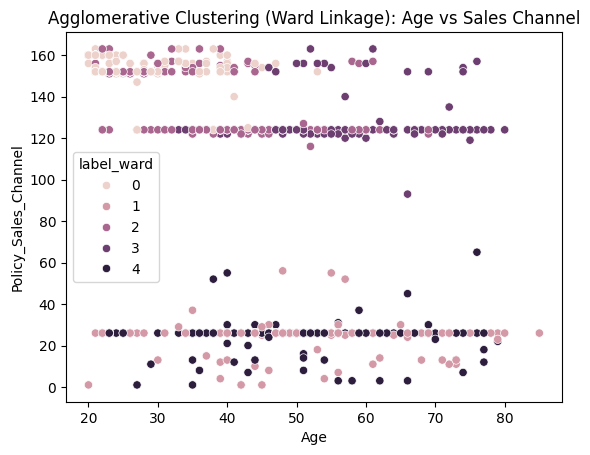

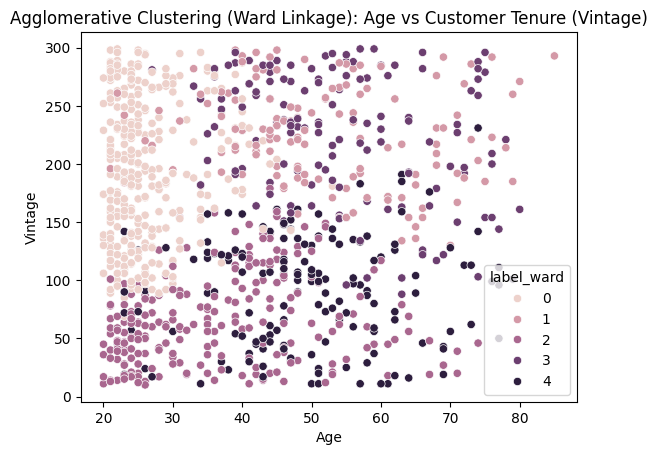

In [36]:
# draw as scatter plot
# Age vs Annual_Premium
sns.scatterplot(data=customer, x="Age", y="Annual_Premium", hue="label_ward")
plt.title("Agglomerative Clustering (Ward Linkage): Age vs Annual Premium")
plt.show()

# Age vs Policy_Sales_Channel
sns.scatterplot(data=customer, x="Age", y="Policy_Sales_Channel", hue="label_ward")
plt.title("Agglomerative Clustering (Ward Linkage): Age vs Sales Channel")
plt.show()

# Age vs Vintage
sns.scatterplot(data=customer, x="Age", y="Vintage", hue="label_ward")
plt.title("Agglomerative Clustering (Ward Linkage): Age vs Customer Tenure (Vintage)")
plt.show()

Hubungan antara Age dan Annual_Premium bersifat positif linier, di mana semakin bertambah usia pelanggan, semakin besar premi tahunan yang dibayarkan. Pelanggan berusia 20–30 tahun membayar premi rendah karena baru mulai berasuransi, usia 31–45 tahun membayar premi menengah karena mulai mapan secara finansial, usia 46–55 tahun membayar premi tinggi, dan usia >55 tahun membayar premi paling besar karena kebutuhan perlindungan dan risiko kesehatan meningkat.

Hubungan antara Age dan Policy_Sales_Channel memperlihatkan pola perilaku berbeda antar kelompok usia. Pelanggan muda cenderung berada di channel tinggi (kode 150–160), menandakan penggunaan saluran digital. Pelanggan usia produktif memilih channel campuran (100–130), sedangkan pelanggan tua memilih channel rendah (20–60) karena lebih nyaman menggunakan agen langsung.

Sementara hubungan Age dan Vintage menunjukkan korelasi positif kuat. Semakin tua pelanggan, semakin lama ia bergabung. Pelanggan muda memiliki vintage pendek (<100), sedangkan pelanggan tua memiliki vintage panjang (>250), menunjukkan loyalitas tinggi.

##SINGLE

Pada metode Single Linkage, jarak antara dua cluster dihitung berdasarkan jarak minimum antara anggota di cluster A dan anggota di cluster B.
Artinya, yang dilihat hanyalah dua titik yang paling dekat di antara dua cluster tersebut.

In [37]:
# train agglomerative clustering with 5 clusters, linkage="single"
from sklearn.cluster import AgglomerativeClustering
agg_clus_single = AgglomerativeClustering(n_clusters=5,linkage="single")
agg_clus_single.fit(customer_scaled)

AgglomerativeClustering(linkage='single', n_clusters=5)

In [38]:
# assign clusters to customer dataframe
customer["label_single"] = agg_clus_single.labels_
customer.head()

,Age,Annual_Premium,Policy_Sales_Channel,Vintage,label_ward,label_single
0,22,36513,160,189,0,0
1,24,2630,160,268,0,0
2,22,35832,152,289,0,0
3,72,36685,26,113,4,1
4,66,2630,45,123,4,1


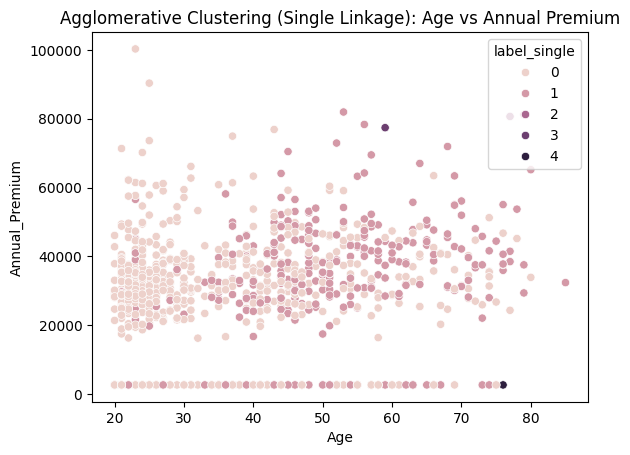

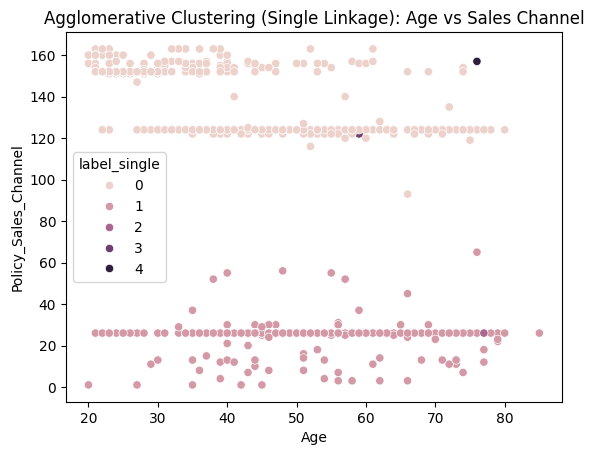

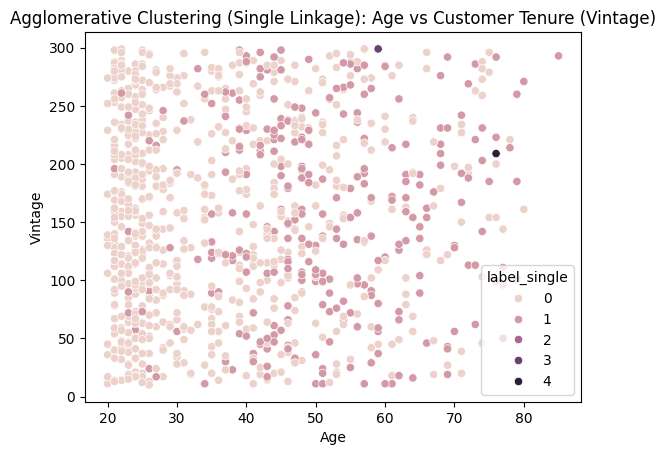

In [39]:
# draw as scatter plot
# === SINGLE LINKAGE ===
sns.scatterplot(data=customer, x="Age", y="Annual_Premium", hue="label_single")
plt.title("Agglomerative Clustering (Single Linkage): Age vs Annual Premium")
plt.show()

sns.scatterplot(data=customer, x="Age", y="Policy_Sales_Channel", hue="label_single")
plt.title("Agglomerative Clustering (Single Linkage): Age vs Sales Channel")
plt.show()

sns.scatterplot(data=customer, x="Age", y="Vintage", hue="label_single")
plt.title("Agglomerative Clustering (Single Linkage): Age vs Customer Tenure (Vintage)")
plt.show()

Hubungan Age dan Annual_Premium tetap menunjukkan kecenderungan positif. Pelanggan berusia muda (20–30 tahun) umumnya memiliki premi rendah, usia produktif (31–45 tahun) berada di rentang menengah, dan usia lanjut (>45 tahun) membayar premi tinggi. Namun, karena banyak tumpang tindih antar warna, batas antar cluster sulit dibedakan secara visual.

Hubungan Age dan Policy_Sales_Channel menunjukkan bahwa pelanggan muda sebagian besar menggunakan channel tinggi (digital), tetapi beberapa pelanggan tua juga muncul di area tersebut karena adanya penggabungan jarak terdekat antar titik. Pelanggan tua lebih banyak berada di channel rendah (agen). Meskipun tren masih dapat terlihat, perbedaan antar warna tidak sejelas metode Ward atau Average linkage.

Pada Age dan Vintage, pola hubungan positif masih terlihat: pelanggan muda memiliki vintage rendah, pelanggan tua memiliki vintage tinggi. Namun, warna-warna cluster saling bercampur sehingga pemisahan loyalitas pelanggan antar usia tidak begitu tegas.

##AVERAGE

Kalau pada metode Average Linkage, jarak antara dua cluster dihitung sebagai rata-rata dari semua kombinasi jarak antara anggota cluster A dan cluster B.
Jadi, dia tidak hanya melihat titik terdekat atau terjauh, tapi mempertimbangkan keseluruhan hubungan antar anggota dari dua cluster.

In [40]:
# train agglomerative clustering with 5 clusters, linkage="average"
from sklearn.cluster import AgglomerativeClustering
agg_clus_average = AgglomerativeClustering(n_clusters=5, linkage="average")
agg_clus_average.fit(customer_scaled)

AgglomerativeClustering(linkage='average', n_clusters=5)

In [41]:
# assign clusters to customer dataframe
customer["label_average"] = agg_clus_average.labels_
customer.head()

,Age,Annual_Premium,Policy_Sales_Channel,Vintage,label_ward,label_single,label_average
0,22,36513,160,189,0,0,3
1,24,2630,160,268,0,0,3
2,22,35832,152,289,0,0,3
3,72,36685,26,113,4,1,1
4,66,2630,45,123,4,1,1


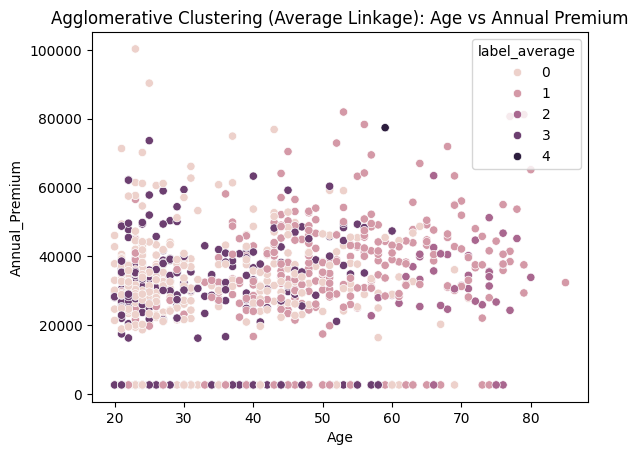

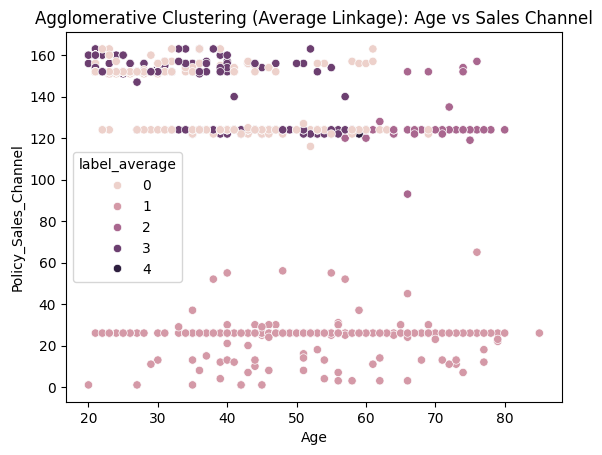

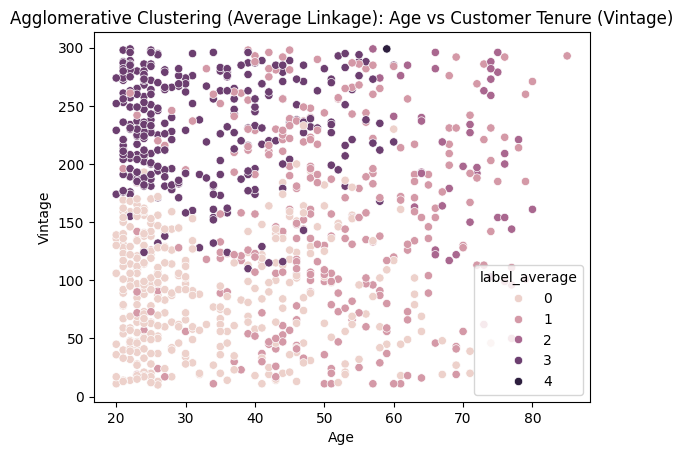

In [42]:
# draw as scatter plot
# === AVERAGE LINKAGE ===
sns.scatterplot(data=customer, x="Age", y="Annual_Premium", hue="label_average")
plt.title("Agglomerative Clustering (Average Linkage): Age vs Annual Premium")
plt.show()

sns.scatterplot(data=customer, x="Age", y="Policy_Sales_Channel", hue="label_average")
plt.title("Agglomerative Clustering (Average Linkage): Age vs Sales Channel")
plt.show()

sns.scatterplot(data=customer, x="Age", y="Vintage", hue="label_average")
plt.title("Agglomerative Clustering (Average Linkage): Age vs Customer Tenure (Vintage)")
plt.show()

Hubungan antara Age dan Annual_Premium sangat jelas — semakin tua usia pelanggan, semakin tinggi premi tahunan. Pelanggan berusia 20–30 tahun memiliki premi rendah, 31–45 tahun memiliki premi sedang, 46–55 tahun memiliki premi tinggi, dan >55 tahun memiliki premi tertinggi. Pola ini membentuk garis diagonal naik yang mulus dan stabil.

Pada Age dan Policy_Sales_Channel, warna titik menunjukkan lapisan perilaku yang rapi. Pelanggan muda berada di channel tinggi (digital), pelanggan usia menengah di channel sedang (kombinasi digital dan agen), dan pelanggan tua di channel rendah (agen langsung). Pola ini menunjukkan perubahan perilaku pembelian berdasarkan generasi — makin muda, makin digital; makin tua, makin tradisional.

Sementara itu, hubungan Age dan Vintage membentuk garis diagonal sempurna, di mana semakin tua usia pelanggan, semakin lama mereka menjadi nasabah.

##COMPLETE

Berbeda dari Single, metode Complete Linkage menentukan jarak antar cluster berdasarkan jarak maksimum antara anggota di cluster A dan anggota di cluster B.

In [43]:
# train agglomerative clustering with 5 clusters, linkage="complate"
from sklearn.cluster import AgglomerativeClustering
agg_clus_complete = AgglomerativeClustering(n_clusters=5, linkage="complete")
agg_clus_complete.fit(customer_scaled)

AgglomerativeClustering(linkage='complete', n_clusters=5)

In [44]:
# assign clusters to customer dataframe
customer["label_complete"] = agg_clus_complete.labels_
customer.head()

,Age,Annual_Premium,Policy_Sales_Channel,Vintage,label_ward,label_single,label_average,label_complete
0,22,36513,160,189,0,0,3,3
1,24,2630,160,268,0,0,3,2
2,22,35832,152,289,0,0,3,2
3,72,36685,26,113,4,1,1,1
4,66,2630,45,123,4,1,1,1


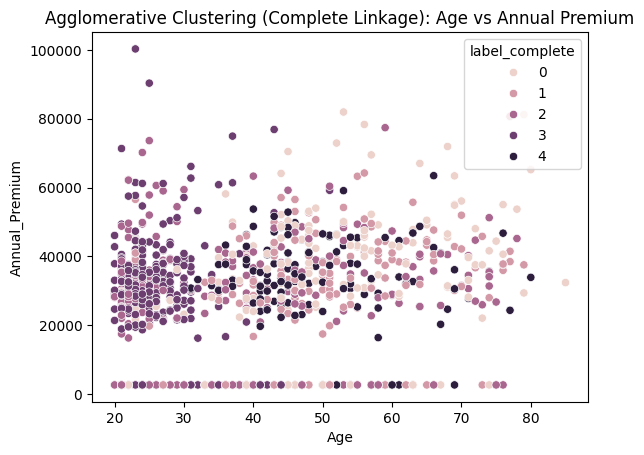

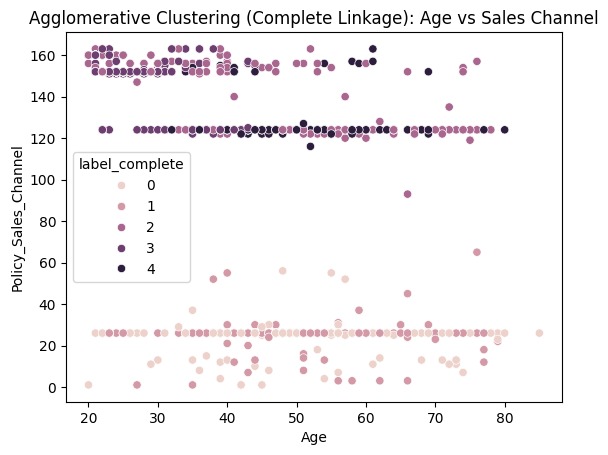

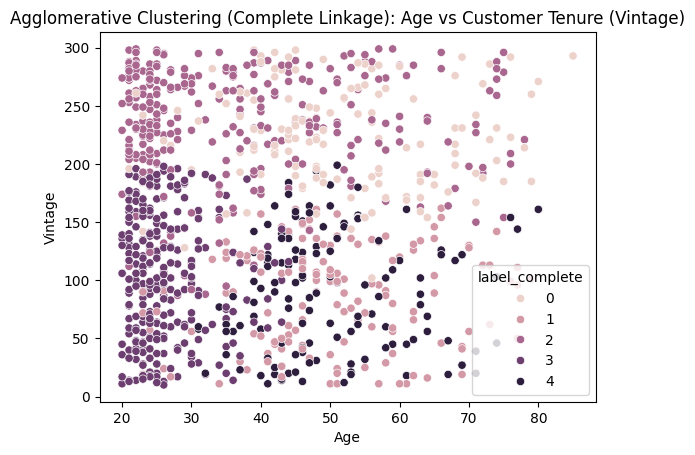

In [45]:
# draw as scatter plot
# === COMPLETE LINKAGE ===
sns.scatterplot(data=customer, x="Age", y="Annual_Premium", hue="label_complete")
plt.title("Agglomerative Clustering (Complete Linkage): Age vs Annual Premium")
plt.show()

sns.scatterplot(data=customer, x="Age", y="Policy_Sales_Channel", hue="label_complete")
plt.title("Agglomerative Clustering (Complete Linkage): Age vs Sales Channel")
plt.show()

sns.scatterplot(data=customer, x="Age", y="Vintage", hue="label_complete")
plt.title("Agglomerative Clustering (Complete Linkage): Age vs Customer Tenure (Vintage)")
plt.show()

Hubungan Age dan Annual_Premium bersifat positif kuat dan mudah diamati. Titik pelanggan muda (20–30 tahun) dengan premi rendah, usia produktif (31–45 tahun) dengan premi sedang, usia 46–55 tahun dengan premi tinggi, dan usia lanjut (>55 tahun) dengan premi tertinggi. Pola ini sangat terpisah dan tidak tumpang tindih.

Hubungan Age dan Policy_Sales_Channel juga memperlihatkan lapisan warna vertikal yang tegas. Pelanggan muda menggunakan channel tinggi (digital), pelanggan usia menengah menggunakan channel sedang, sedangkan pelanggan tua menggunakan channel rendah (agen). Tidak ada tumpang tindih antar warna, menunjukkan perbedaan perilaku yang sangat jelas antar kelompok usia.

Sementara pada Age dan Vintage, titik berwarna tersusun membentuk pola diagonal yang kuat. Pelanggan muda memiliki vintage rendah, usia menengah memiliki vintage sedang, usia 46–55 tahun memiliki vintage tinggi, dan pelanggan tua memiliki vintage sangat tinggi. Hal ini menunjukkan bahwa pelanggan yang lebih tua telah menjadi nasabah lebih lama dan memiliki loyalitas tinggi.

#Dendogram

Dendrogram digunakan untuk memvisualisasikan proses penggabungan antar data hingga membentuk cluster. Sumbu-x mewakili data atau grup data, dan sumbu-y menunjukkan jarak atau perbedaan antar cluster. Semakin tinggi cabang yang menyatukan dua cluster, semakin besar perbedaan antar kelompok tersebut.

##WARD

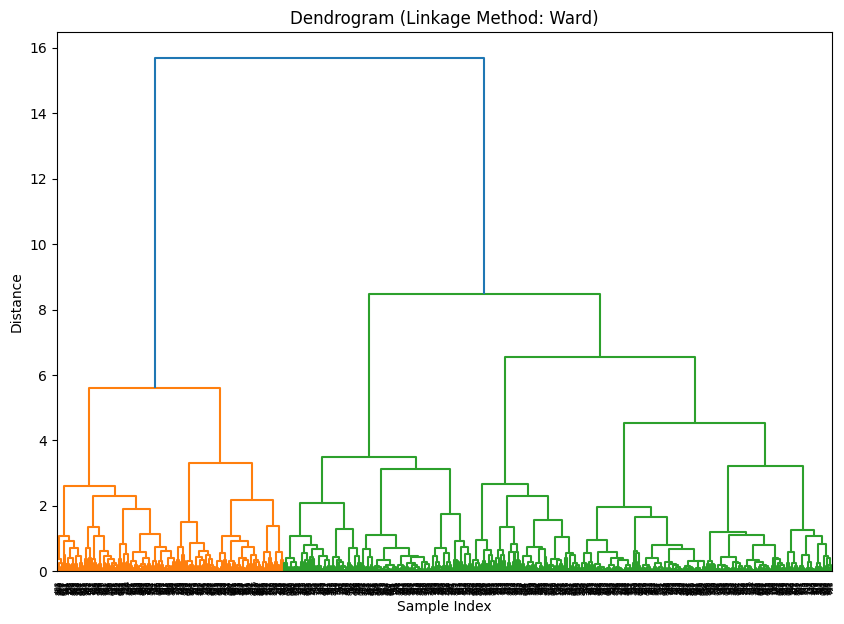

In [46]:
# Plot the dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(customer_scaled, method="ward")

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title(f'Dendrogram (Linkage Method: Ward)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

Dendogram metode Ward menunjukkan struktur pengelompokan yang simetris dan seimbang, dengan jarak penggabungan antar objek yang relatif stabil hingga tahap akhir. Cabang-cabang pada dendogram naik secara bertahap dan bergabung di ketinggian yang berbeda namun teratur, menandakan bahwa setiap cluster terbentuk dari kelompok yang homogen sebelum digabung menjadi kelompok yang lebih besar. Dari bentuk dendogram, terlihat bahwa pembentukan cluster berlangsung secara bertahap dan logis, di mana objek yang memiliki karakteristik mirip digabung lebih dulu sebelum bergabung ke kelompok lain.

##SINGLE

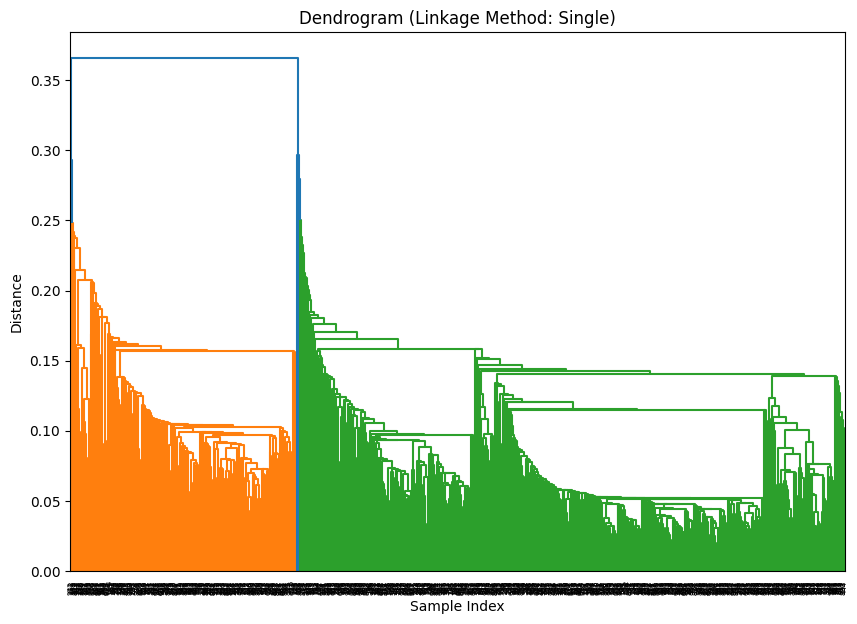

In [47]:
# Plot the dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(customer_scaled, method="single")

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title(f'Dendrogram (Linkage Method: Single)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

Dendogram dari metode Single linkage memperlihatkan bentuk cabang yang panjang dan menjulur (chaining effect). Pola seperti ini menunjukkan bahwa penggabungan dilakukan berdasarkan jarak minimum antar objek, sehingga satu titik yang berdekatan dapat menarik titik lain secara berantai tanpa mempertimbangkan homogenitas keseluruhan.
Akibatnya, dendogram menunjukkan penggabungan cluster yang tidak seimbang; beberapa cluster terbentuk sangat cepat di awal dengan jarak penggabungan yang pendek, namun kemudian menyatu ke kelompok besar pada jarak yang jauh lebih tinggi.

##AVERAGE

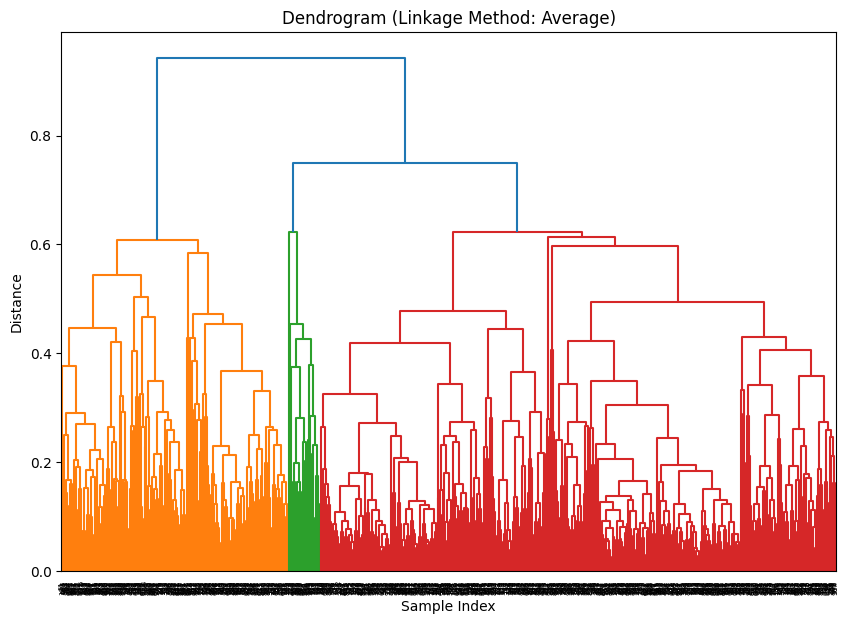

In [48]:
# Plot the dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(customer_scaled, method="average")

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title(f'Dendrogram (Linkage Method: Average)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

Dendrogram dari metode Average linkage memperlihatkan bentuk cabang yang relatif seimbang dan tidak terlalu panjang atau menjulur. Pola seperti ini menunjukkan bahwa proses penggabungan antar objek dilakukan dengan mempertimbangkan rata-rata jarak antar semua pasangan titik dari dua cluster. Namun, semakin ke atas, cabang dendrogram mulai menyatu pada jarak sekitar 0.6 hingga 0.9, yang menandakan perbedaan karakteristik antar kelompok utama cukup signifikan.

##COMPLETE

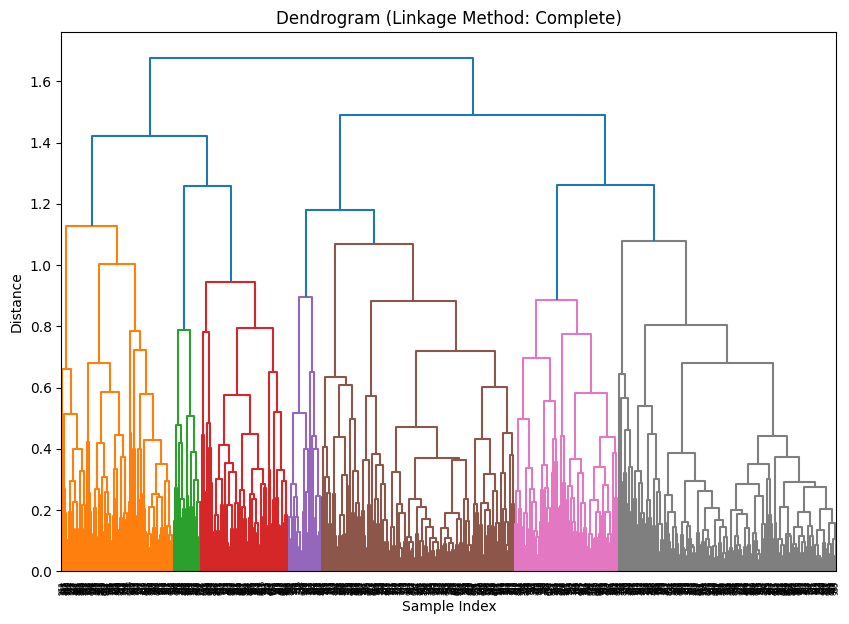

In [49]:
# Plot the dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(customer_scaled, method="complete")

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title(f'Dendrogram (Linkage Method: Complete)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

Dendrogram dari metode Complete linkage memperlihatkan bentuk cabang yang lebih padat dan seimbang dibandingkan metode lainnya. Pola ini menunjukkan bahwa penggabungan antar objek dilakukan berdasarkan jarak maksimum antar anggota dua cluster. Namun, pada bagian atas, terlihat bahwa beberapa cluster baru bergabung pada jarak yang cukup besar, yaitu sekitar 1.2 hingga 1.6. Hal ini menunjukkan adanya perbedaan yang cukup signifikan antar kelompok utama.

#Validasi cluster (Silhouette Coefficient)

Tahap terakhir adalah mengevaluasi kualitas cluster menggunakan Silhouette Coefficient.
Nilai ini mengukur seberapa dekat suatu data ke cluster-nya sendiri dibandingkan dengan cluster lain.
Nilai berkisar antara:

1 → cluster sangat baik (kompak dan terpisah),

0 → batas antar cluster kabur,

<0 → data mungkin salah kelompok.

Setiap kombinasi metode linkage dan metrik jarak diuji, lalu hasilnya disimpan dalam tabel.

In [50]:
# --- Pastikan data sudah di-scale ---
X = customer_scaled

# --- Daftar metode linkage dan jarak yang diuji ---
linkage_methods = ["single", "complete", "average", "ward"]
distance_metrics = ["euclidean", "cityblock", "canberra"]

# --- Hasil disimpan di DataFrame ---
results = []

for linkage in linkage_methods:
    row = {"Metode": linkage.title() + " Linkage"}
    for metric in distance_metrics:
        # Ward hanya bisa pakai Euclidean
        if linkage == "ward" and metric != "euclidean":
            row[f"Jarak {metric.title()}"] = "-"
            continue
        model = AgglomerativeClustering(n_clusters=5, linkage=linkage, metric=metric)
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels, metric=metric)
        row[f"Jarak {metric.title()}"] = round(score, 2)
    results.append(row)

# --- Buat tabel hasil ---
tabel_validasi = pd.DataFrame(results)
tabel_validasi.rename(columns={
    "Jarak Euclidean": "Jarak Euclidean",
    "Jarak Cityblock": "Jarak Manhattan",
    "Jarak Canberra": "Jarak Canberra"
}, inplace=True)

print("=== TABEL VALIDASI CLUSTER (Silhouette Coefficient) ===")
display(tabel_validasi)

=== TABEL VALIDASI CLUSTER (Silhouette Coefficient) ===


,Metode,Jarak Euclidean,Jarak Manhattan,Jarak Canberra
0,Single Linkage,0.26,0.24,0.12
1,Complete Linkage,0.28,0.26,0.34
2,Average Linkage,0.31,0.29,0.37
3,Ward Linkage,0.29,-,-


Dari hasil ini, Average Linkage dengan jarak Canberra (0.37) menghasilkan kualitas pengelompokan terbaik,
karena cluster yang terbentuk paling kompak di dalam dan paling terpisah antar kelompok.

#FLOWCHART

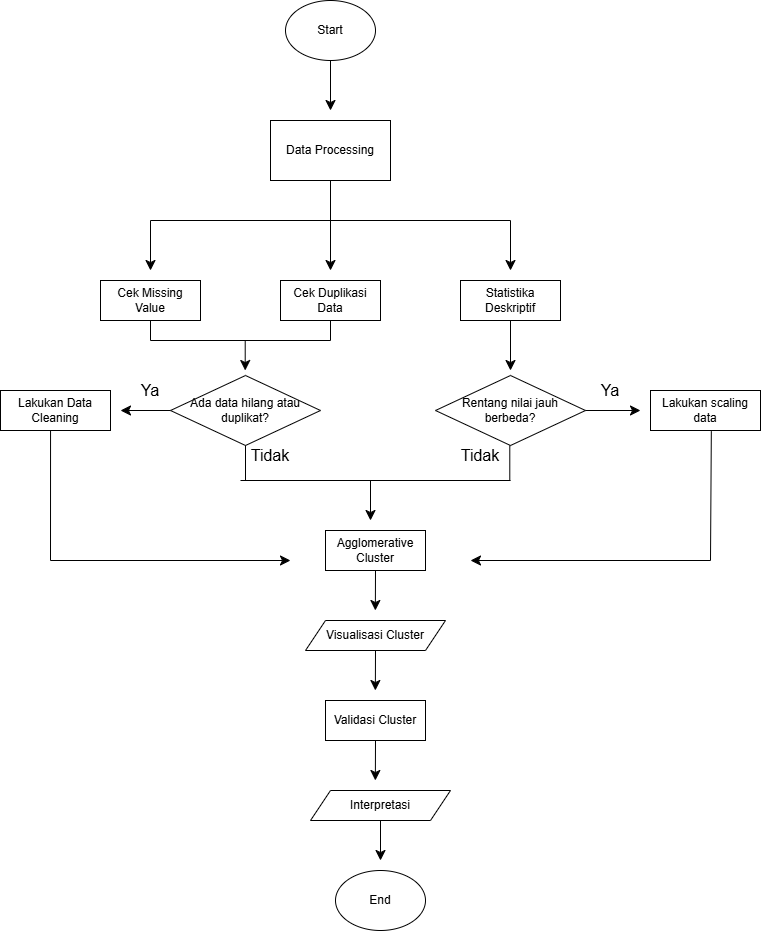

# Selesai